In [43]:
import qiskit
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import op_converter
from qiskit.aqua.operators import WeightedPauliOperator


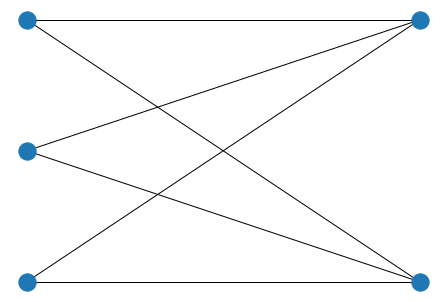

In [44]:
G=nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G,nx.bipartite_layout(G,[0,1,2]))


In [45]:
def append_zz_term(qc,q1,q2,gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma,q2)
    qc.cx(q1,q2)


In [46]:
def get_cost_circuit(G,gamma):
    N=G.number_of_nodes()
    qc=QuantumCircuit(N,N)
    for i,j in G.edges():
        append_zz_term(qc,i,j,gamma)
    return qc
#print(get_cost_circuit(G,0.5))

In [65]:
def append_x_term(qc,q1,beta):
    qc.rx(2*beta,q1)

def get_mixer_operator(G,beta):
    N=G.number_of_nodes()
    qc=QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc,n,beta)
    return qc

#print(get_mixer_operator(G,0.5))


In [48]:
def get_QAOA_circuit(G,beta,gamma):
    assert(len(beta)==len(gamma))
    N=G.number_of_nodes()
    qc=QuantumCircuit(N,N)
    qc.h(range(N))
    p=len(beta)
    #aplicamos las p rotaciones
    for i in range(p):
        qc=qc.compose(get_cost_circuit(G,gamma[i]))
        qc=qc.compose(get_mixer_operator(G,beta[i]))
    qc.barrier(range(N))
    qc.measure(range(N),range(N))
    return qc
    
print(get_QAOA_circuit(G,[0.5,0,6],[0.5,0,6]))    

        

     ┌───┐                                               ┌───────┐          »
q_0: ┤ H ├──■─────────────■────■──────────────────────■──┤ RZ(1) ├──────────»
     ├───┤  │             │    │    ┌───┐  ┌───────┐  │  └─┬───┬─┘     ┌───┐»
q_1: ┤ H ├──┼─────────────┼────┼────┤ X ├──┤ RZ(1) ├──┼────┤ X ├───────┤ X ├»
     ├───┤  │             │    │    └─┬─┘  └───────┘  │    └─┬─┘  ┌───┐└─┬─┘»
q_2: ┤ H ├──┼─────────────┼────┼──────┼───────────────┼──────┼────┤ X ├──┼──»
     ├───┤┌─┴─┐┌───────┐┌─┴─┐  │      │               │      │    └─┬─┘  │  »
q_3: ┤ H ├┤ X ├┤ RZ(1) ├┤ X ├──┼──────■───────────────┼──────■──────■────┼──»
     ├───┤└───┘└───────┘└───┘┌─┴─┐┌───────┐         ┌─┴─┐                │  »
q_4: ┤ H ├───────────────────┤ X ├┤ RZ(1) ├─────────┤ X ├────────────────■──»
     └───┘                   └───┘└───────┘         └───┘                   »
c: 5/═══════════════════════════════════════════════════════════════════════»
                                                                

In [49]:
def invert_counts(counts):
    return {k[::-1] :v for k,v in counts.items()}

qc=get_QAOA_circuit(G,[0.5,0,6],[0.5,0,6])   
backend=Aer.get_backend('qasm_simulator')
job=execute(qc,backend)
result=job.result()
print(invert_counts(result.get_counts()))

{'00100': 35, '01001': 36, '00110': 39, '01110': 34, '00001': 31, '10000': 38, '11001': 36, '00111': 32, '00010': 46, '10101': 21, '11100': 24, '01100': 29, '01101': 25, '11011': 34, '10010': 30, '10001': 33, '00000': 37, '01011': 21, '00011': 31, '01111': 24, '10011': 37, '01000': 30, '11010': 31, '10100': 35, '11111': 37, '10111': 31, '11110': 26, '11101': 29, '11000': 32, '10110': 35, '01010': 36, '00101': 29}


In [63]:
def maxcut_obj(x,G):
    cut=0
    for i,j in G.edges():
        if x[i]!=x[j]:
            cut = cut-1
    return cut
print(maxcut_obj("00011",G))

-6


In [61]:
def compute_maxcut_energy(counts,G):
    energy=0
    get_counts=0
    total_counts=0
    for meas, meas_count in counts.items():
        obj_for_meas=maxcut_obj(meas,G)
        energy+=obj_for_meas*meas_count
        total_counts+=meas_count
    return energy/total_counts

In [62]:
def get_black_box_objective(G,p):
    backend=Aer.get_backend('qasm_simulator')
    def f(theta):
        beta=theta[:p]
        gamma=theta[p:]
        qc=get_QAOA_circuit(G,beta,gamma)
        counts=execute(qc,backend,seed_simulator=10).result().get_counts()
        return compute_maxcut_energy(invert_counts(counts),G)
    return f
p=5
obj=get_black_box_objective(G,p)
init_point=np.array([0.8,2.2,0.83,2.15,0.37,2.4,6.1,2.2,3.8,6.1])#([2,2,1,1,1,1,1,1,1,1])
res_sample=minimize(obj, init_point,method="COBYLA",options={"maxiter":2500,"disp":True})

res_sample
        

     fun: -3.0068359375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 61
  status: 1
 success: True
       x: array([0.8 , 2.2 , 0.83, 2.15, 0.37, 2.4 , 6.1 , 2.2 , 3.8 , 6.1 ])